In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-23 19:58:47 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-23 19:58:47 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-23 19:58:47 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-23 19:58:49 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-23 19:58:49 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-23 19:58:49 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-23 19:58:49 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-23 19:58:50 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-23 19:58:50 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-10-23 19:58:50 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-10-23 19:58:50 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-10-23 19:58:50 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-23 19:59:30 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-10-23 19:59:30 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-23 19:59:30 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import CounterFactualSamplePair

with open("/disk/u/arnab/Codes/Projects/retrieval/results/selection/ov_contribution/Llama-3.3-70B-Instruct/distinct_options/select_one_mcq/legacy/samples/train/sample_00017.json", "r") as f:
    cf_pair_data = json.load(f)

cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
clean_sample = cf_pair.clean_sample
patch_sample = cf_pair.patch_sample

print("patch:", patch_sample.prompt(), " >> ", mt.tokenizer.decode(patch_sample.ans_token_id))
print("clean:", clean_sample.prompt(), " >> ", mt.tokenizer.decode(clean_sample.ans_token_id))

print(mt.tokenizer.decode(clean_sample.metadata["track_type_obj_token_id"]))

patch: a. Sweater
b. Chain
c. Keyboard
d. Tractor
e. Hospital
f. Lavender
Which among these objects mentioned above is a clothing?
Answer:  >>   a
clean: p. Notebook
q. Laptop
r. Giraffe
s. Lily
t. Socks
u. Bike
Which among these objects mentioned above is a flower?
Answer:  >>   s
 t


In [6]:
clean_sample.metadata["track_type_obj"]

'Socks'

In [7]:
import baukit
from src.selection.optimization import increase_logit_in_latents
from src.tokens import prepare_input

destination_tokenized = prepare_input(
    prompts=[clean_sample.prompt()],
    tokenizer=mt.tokenizer,
)
locations = [
    (mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(55, 66)
]
with baukit.TraceDict(mt._model, layers=[layer for layer, _ in locations]) as trace_dict:
    outputs = mt._model(**destination_tokenized)

latents = {
    (layer_name, token_idx): trace_dict[layer_name].output[:, token_idx, :]
    for layer_name, token_idx in locations
}

increase_logit_in_latents(
    mt=mt,
    destination_samples=[clean_sample],
    latents=latents,
)

(tensor(-9.2500, device='cuda:7', dtype=torch.bfloat16, grad_fn=<DivBackward0>),
 {('model.layers.55', -1): 10.0,
  ('model.layers.56', -1): 10.0625,
  ('model.layers.57', -1): 9.75,
  ('model.layers.58', -1): 9.3125,
  ('model.layers.59', -1): 9.9375,
  ('model.layers.60', -1): 9.0625,
  ('model.layers.61', -1): 8.625,
  ('model.layers.62', -1): 8.3125,
  ('model.layers.63', -1): 8.625,
  ('model.layers.64', -1): 9.0625,
  ('model.layers.65', -1): 9.0})

In [8]:
from src.functional import logit_lens
from src.selection.utils import get_first_token_id

logit_lens(
    mt=mt,
    h=latents[("model.layers.60", -1)],
    interested_tokens=[
        get_first_token_id(
            name=clean_sample.metadata["track_type_obj"], tokenizer=mt.tokenizer
        )
    ],
)

([PredictedToken(token=' option', prob=0.51171875, logit=13.625, token_id=3072, metadata=None),
  PredictedToken(token=' Option', prob=0.1220703125, logit=12.1875, token_id=7104, metadata=None),
  PredictedToken(token='option', prob=0.1220703125, logit=12.1875, token_id=2091, metadata=None),
  PredictedToken(token=' Lily', prob=0.107421875, logit=12.0625, token_id=48390, metadata=None),
  PredictedToken(token='Option', prob=0.013671875, logit=10.0, token_id=5454, metadata=None)],
 OrderedDict([(328,
               (6,
                PredictedToken(token=' S', prob=0.005340576171875, logit=9.0625, token_id=328, metadata=None)))]))

In [9]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



2025-10-23 20:00:26 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-10-23 20:00:26 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-10-23 20:00:26 matplotlib DEBUG    interactive is False
2025-10-23 20:00:26 matplotlib DEBUG    platform is linux
2025-10-23 20:00:26 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-10-23 20:00:26 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
####################################################################################################
Processing predicate...
####################################################################################################
2025-10-23 20:00:26 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-23 20:00:26 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_

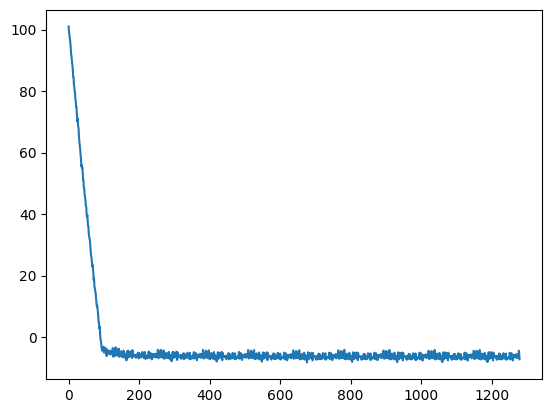

101 heads selected for predicate


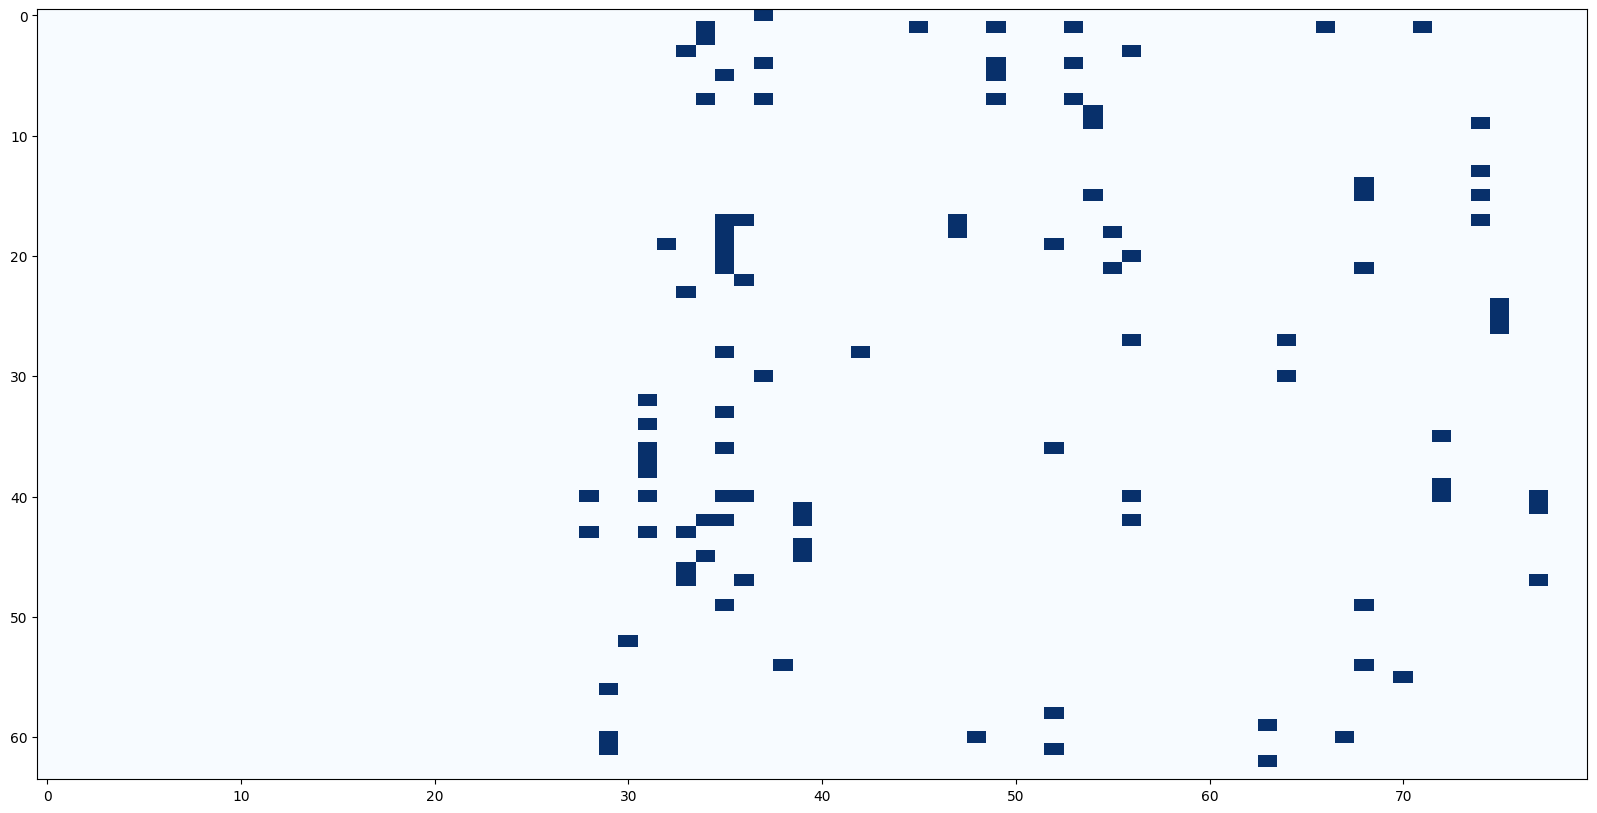

####################################################################################################
Processing pointer...
####################################################################################################


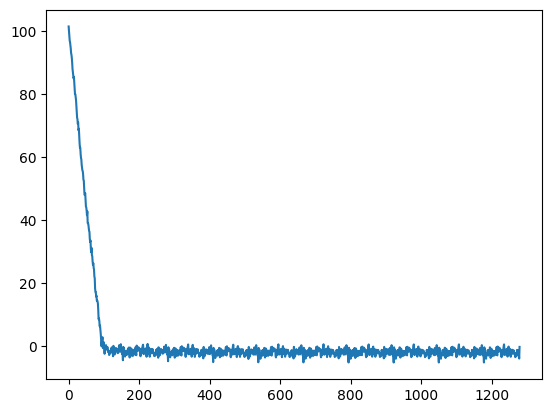

57 heads selected for pointer


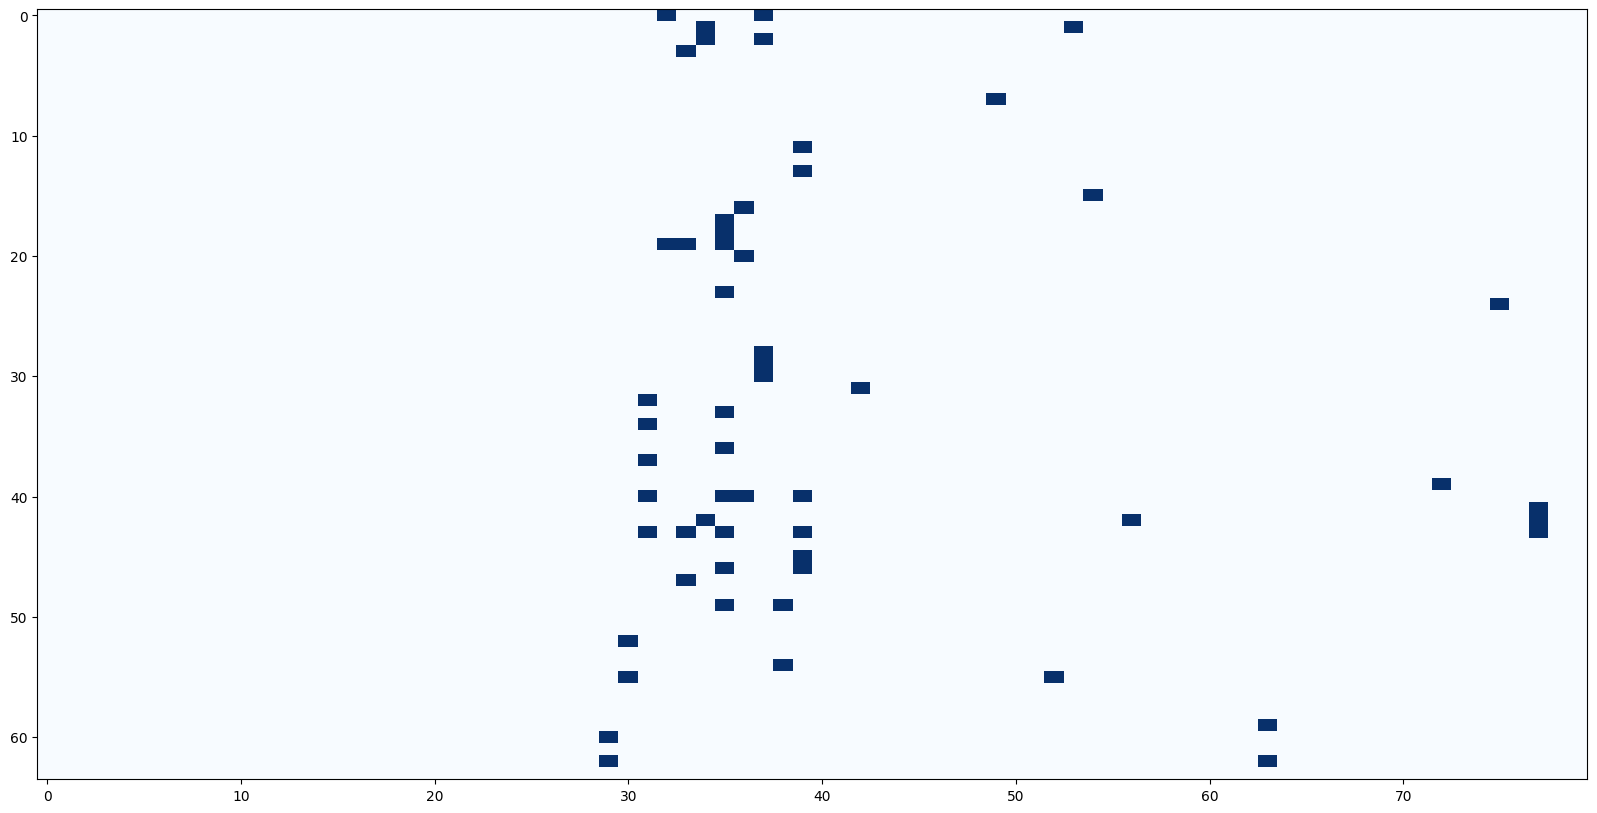

####################################################################################################
Processing latent_logit...
####################################################################################################


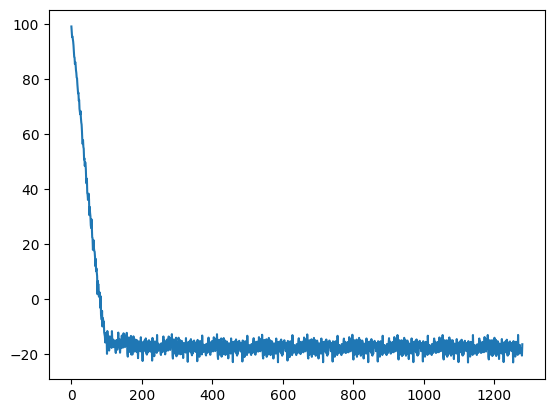

216 heads selected for latent_logit


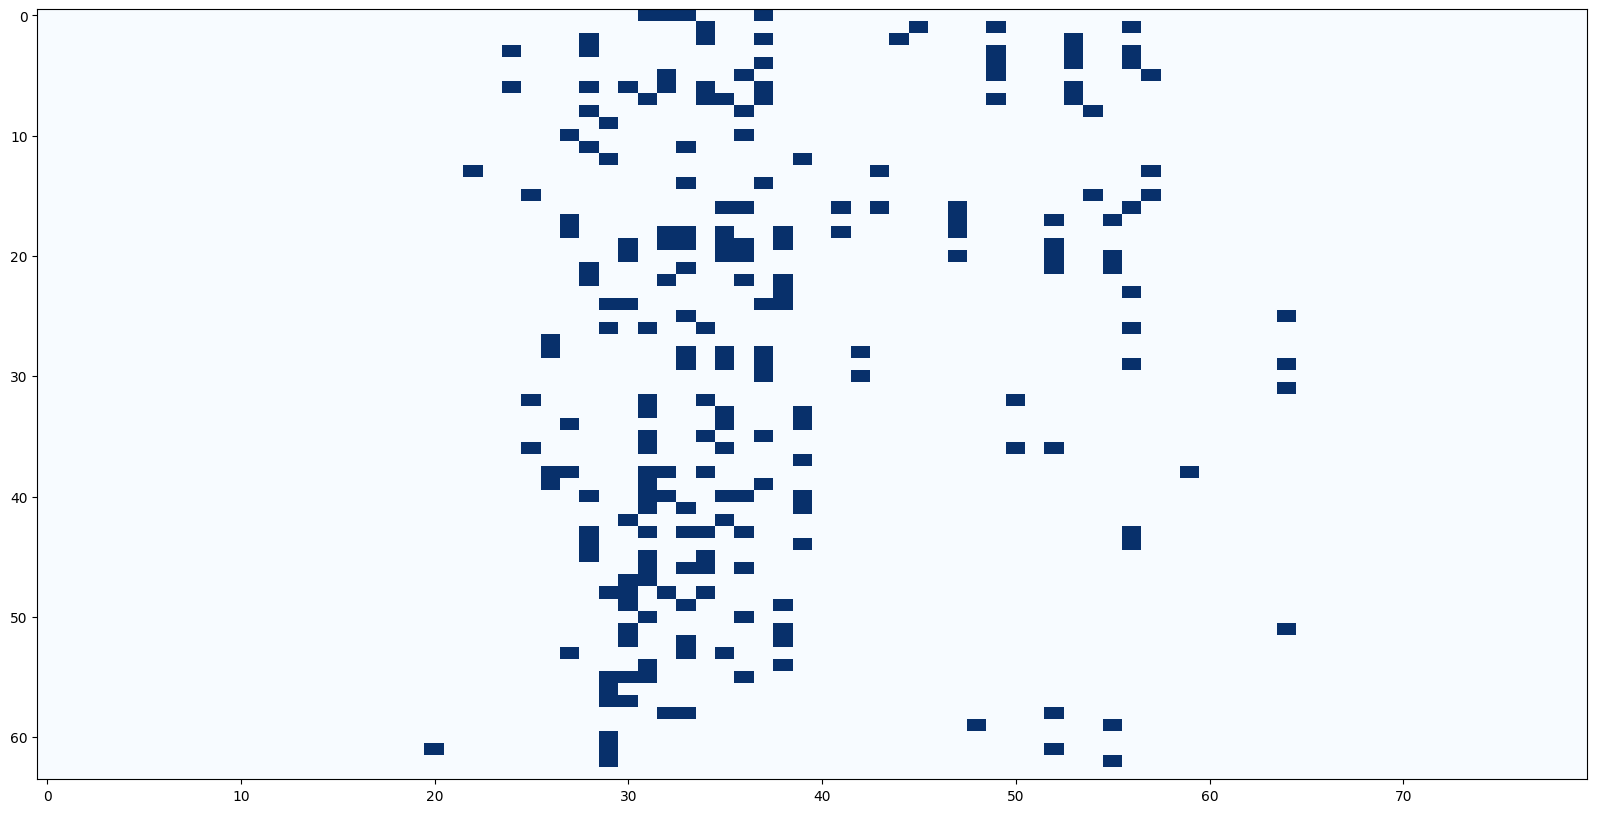

In [10]:
from matplotlib import pyplot as plt
import numpy as np

config = {
    "predicate": "distinct_options",
    "pointer": "ans_pointer",
    "latent_logit": "distinct_options"
}
heads_selected = {key: None for key in config.keys()}

for target_concept, folder_id in config.items():
    print("#"*100)
    print(f"Processing {target_concept}...")
    print("#"*100)
    root = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR,
        "selection/ov_contribution"
    )
    if target_concept == "latent_logit":
        root = os.path.join(
            root, "latent_logit"
        )
    optimized_path = os.path.join(
        root,
        model_key.split("/")[-1],
        folder_id,
        "select_one_mcq",
        "legacy",
        "epoch_10.npz"
    )
    optimization_results = np.load(optimized_path, allow_pickle=True)
    losses = optimization_results["losses"]
    plt.plot(losses)
    plt.show()

    plt.figure(figsize=(20, 10))
    optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
    # optimal_head_mask[52:, :] = 0.0

    plt.imshow(
        optimal_head_mask.T.numpy(),
        cmap="Blues",
        aspect="auto",
        vmin=0,
        vmax=1,
    )

    heads_selected[target_concept] = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
    heads_selected[target_concept] = [
        (layer_idx, head_idx) for layer_idx, head_idx in heads_selected[target_concept]
    ]
    print(len(heads_selected[target_concept]), "heads selected for", target_concept)
    plt.show()

2025-10-23 20:00:35 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-10-23 20:00:35 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-10-23 20:00:35 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-10-23 20:00:35 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.tt

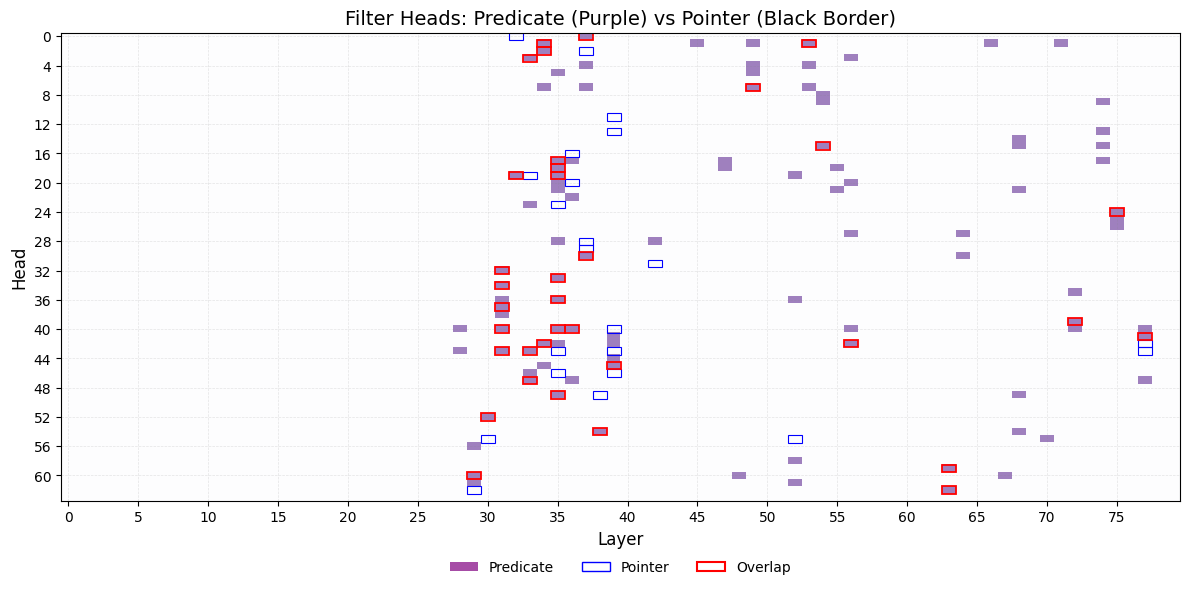

Total heads for predicate: 101
Total heads for pointer: 57
Overlapping heads: 35
Overlapping positions: [(29, 60), (30, 52), (31, 32), (31, 34), (31, 37), (31, 40), (31, 43), (32, 19), (33, 3), (33, 43), (33, 47), (34, 1), (34, 2), (34, 42), (35, 17), (35, 18), (35, 19), (35, 33), (35, 36), (35, 40), (35, 49), (36, 40), (37, 0), (37, 30), (38, 54), (39, 45), (49, 7), (53, 1), (54, 15), (56, 42), (63, 59), (63, 62), (72, 39), (75, 24), (77, 41)]


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

colors = {
    "predicate": "Purples",
    "pointer": "Blues",
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Start with base visualization for predicate heads
predicate_mask = np.zeros((mt.config.num_attention_heads, mt.n_layer))
for layer_idx, head_idx in heads_selected["predicate"]:
    predicate_mask[head_idx, layer_idx] = 1.0

# Plot predicate heads as colored heatmap
im = ax.imshow(
    predicate_mask,
    cmap=colors["predicate"],
    aspect="auto",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    alpha=0.5,
)

# Find overlapping heads
overlapping_heads = []
for head in heads_selected["predicate"]:
    if head in heads_selected["pointer"]:
        overlapping_heads.append(head)

# Draw dark borders for pointer heads (excluding overlaps)
for layer_idx, head_idx in heads_selected["pointer"]:
    if (layer_idx, head_idx) not in overlapping_heads:
        rect = mpatches.Rectangle(
            (layer_idx - 0.5, head_idx - 0.5),
            1,
            1,
            fill=False,
            edgecolor="blue",
            linewidth=0.8,
        )
        ax.add_patch(rect)

# Draw thicker red borders for overlapping heads
for layer_idx, head_idx in overlapping_heads:
    rect = mpatches.Rectangle(
        (layer_idx - 0.5, head_idx - 0.5),
        1,
        1,
        fill=False,
        edgecolor="red",
        linewidth=1.3,
    )
    ax.add_patch(rect)

# Add labels and formatting
ax.set_xlabel("Layer", fontsize=12)
ax.set_ylabel("Head", fontsize=12)
ax.set_title("Filter Heads: Predicate (Purple) vs Pointer (Black Border)", fontsize=14)

# Add grid for clarity
ax.set_xticks(np.arange(0, mt.n_layer, 5))
ax.set_yticks(np.arange(0, mt.config.num_attention_heads, 4))
ax.grid(True, alpha=0.2, linestyle="--", color="gray", linewidth=0.5)

# Create custom legend
legend_elements = [
    mpatches.Patch(facecolor="purple", alpha=0.7, label="Predicate"),
    mpatches.Patch(facecolor="white", edgecolor="blue", linewidth=1, label="Pointer"),
    mpatches.Patch(facecolor="white", edgecolor="red", linewidth=1.5, label="Overlap"),
]
ax.legend(
    handles=legend_elements,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    fontsize=10,
    frameon=False,
)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Total heads for predicate: {len(heads_selected['predicate'])}")
print(f"Total heads for pointer: {len(heads_selected['pointer'])}")
print(f"Overlapping heads: {len(overlapping_heads)}")
if overlapping_heads:
    print(f"Overlapping positions: {overlapping_heads}")

In [75]:
from src.selection.data import MCQify_sample

sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)
sample = MCQify_sample(sample = sample, tokenizer = mt, start_from="p")

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

fruit >> ['Grape', 'Pear', 'Banana', 'Orange', 'Kiwi', 'Cherry', 'Mango', 'Plum', 'Strawberry', 'Blueberry', 'Raspberry', 'Apple', 'Watermelon', 'Pineapple', 'Peach']
p. Chair
q. Monitor
r. Pendant
s. Watermelon
t. Submarine
u. Socks
Which among these objects mentioned above is a fruit?
Answer: >> " s"


In [76]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(),
    options=sample.options,
    mt=mt,
    heads=heads_selected["predicate"],
    # heads=heads_selected["pointer"],
    start_from=1
)

2025-10-23 20:44:33 src.selection.functional DEBUG    Predictions: ['" s"[274] (p=0.777, logit=21.250)', '" ("[320] (p=0.093, logit=19.125)', '" Option"[7104] (p=0.030, logit=18.000)', '" S"[328] (p=0.023, logit=17.750)', '" The"[578] (p=0.023, logit=17.750)']
2025-10-23 20:44:33 src.selection.functional INFO     Combined attention matrix for all heads


## Apply Logit Lens on the OV contribution

In [77]:
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
import copy
import baukit
from src.functional import patch_with_baukit, interpret_logits, get_hs
from src.selection.utils import get_first_token_id
from src.tokens import prepare_input

# HEADS = copy.deepcopy(heads_selected)
HEADS = heads_selected["latent_logit"]
# HEADS = heads_selected["pointer"]
# HEADS = heads_selected["predicate"]

HEADS = [(layer_idx, head_idx) for layer_idx, head_idx in HEADS if layer_idx <= 52]

tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)

mt.reset_forward()
mt.set_attn_implementation("sdpa")

layers_to_heads = {}
for layer_idx, head_idx in HEADS:
    if layer_idx not in layers_to_heads:
        layers_to_heads[layer_idx] = []
    layers_to_heads[layer_idx].append(head_idx)

head_contributions = {}
for layer_idx, head_indices in layers_to_heads.items():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    head_contributions[layer_idx] = {}

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=head_indices,
            store_head_contributions=head_contributions[layer_idx],
        ),
        attn_block,
    )

logit_location = (mt.lm_head_name, -1)
logit = get_hs(
    mt=mt,
    input=tokenized,
    locations = logit_location,
    return_dict=False
)

mt.reset_forward()
mt.set_attn_implementation("eager")

pred = interpret_logits(
    logits=logit,
    tokenizer=mt.tokenizer,
)
pred

2025-10-23 20:44:42 src.hooking.llama_attention WARNING  model.layers.34.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=25.625, __attn_output.norm().item()=25.625


[PredictedToken(token=' s', prob=0.76953125, logit=21.125, token_id=274, metadata=None),
 PredictedToken(token=' (', prob=0.091796875, logit=19.0, token_id=320, metadata=None),
 PredictedToken(token=' Option', prob=0.02978515625, logit=17.875, token_id=7104, metadata=None),
 PredictedToken(token=' The', prob=0.0262451171875, logit=17.75, token_id=578, metadata=None),
 PredictedToken(token=' S', prob=0.0262451171875, logit=17.75, token_id=328, metadata=None)]

In [78]:
from src.functional import logit_lens
from src.selection.data import get_options_for_answer

# head_contrib = head_contributions[35][19][:, -1, :]
head_contrib = []
for layer_idx, head_idx in HEADS:
    head_contrib.append(
        head_contributions[layer_idx][head_idx][:, -1, :].squeeze().cuda()
    )

head_contrib = torch.stack(head_contrib).sum(dim=0)

logit_lens(
    mt=mt,
    h=head_contrib,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ],
    k=20
)

# head_contrib.shape

([PredictedToken(token='нь', prob=0.0078125, logit=8.5625, token_id=101229, metadata=None),
  PredictedToken(token='viso', prob=0.006072998046875, logit=8.3125, token_id=73549, metadata=None),
  PredictedToken(token=' sophistic', prob=0.00537109375, logit=8.1875, token_id=24940, metadata=None),
  PredictedToken(token=' hã', prob=0.004180908203125, logit=7.9375, token_id=104619, metadata=None),
  PredictedToken(token=' Pais', prob=0.002960205078125, logit=7.59375, token_id=82887, metadata=None),
  PredictedToken(token=' Pierce', prob=0.00286865234375, logit=7.5625, token_id=50930, metadata=None),
  PredictedToken(token=' pard', prob=0.0027008056640625, logit=7.5, token_id=91047, metadata=None),
  PredictedToken(token='heet', prob=0.002532958984375, logit=7.4375, token_id=3759, metadata=None),
  PredictedToken(token='_LS', prob=0.002166748046875, logit=7.28125, token_id=88889, metadata=None),
  PredictedToken(token='illi', prob=0.00191497802734375, logit=7.15625, token_id=58268, metadata

In [79]:
from src.functional import patchscope

patchscope(
    mt=mt,
    h=head_contrib,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ],
    patch_layers=[mt.layer_name_format.format(layer_idx) for layer_idx in range(5, 6)],
    k=20
)

2025-10-23 20:44:48 src.functional DEBUG     copy > copy
 Cat > Cat
 Java > Java
 transistor > transistor
 python > python
 Leonardo DiCaprio > Leonardo DiCaprio
 The Lion King > The Lion King
 Washington D.C. > Washington D.C.
 Mount Everest > Mount Everest
 computer > computer
 x >
2025-10-23 20:44:48 src.functional WARNING  placeholder='x' does not end with placeholder_ends=' x' | placeholder_idx=58


([PredictedToken(token=' ', prob=0.8515625, logit=15.75, token_id=220, metadata=None),
  PredictedToken(token=' o', prob=0.0107421875, logit=11.375, token_id=297, metadata=None),
  PredictedToken(token=' s', prob=0.01007080078125, logit=11.3125, token_id=274, metadata=None),
  PredictedToken(token='8', prob=0.006103515625, logit=10.8125, token_id=23, metadata=None),
  PredictedToken(token=' \n', prob=0.0047607421875, logit=10.5625, token_id=720, metadata=None),
  PredictedToken(token=' x', prob=0.002105712890625, logit=9.75, token_id=865, metadata=None),
  PredictedToken(token=' b', prob=0.00164031982421875, logit=9.5, token_id=293, metadata=None),
  PredictedToken(token=' oct', prob=0.0015411376953125, logit=9.4375, token_id=18998, metadata=None),
  PredictedToken(token=' a', prob=0.0014495849609375, logit=9.375, token_id=264, metadata=None),
  PredictedToken(token=' f', prob=0.00128173828125, logit=9.25, token_id=282, metadata=None),
  PredictedToken(token=' -', prob=0.00112915039062

In [17]:
from src.functional import free_gpu_cache
del head_contributions
del head_contrib
free_gpu_cache()

In [18]:
sample.obj, sample.ans_token_id

('Blueberry', 259)

## SAE

In [31]:
from huggingface_hub import hf_hub_download

SAE_NAME = "Llama-3.3-70B-Instruct-SAE-l50"
file_path = hf_hub_download(
    repo_id=f"Goodfire/{SAE_NAME}",
    filename=f"{SAE_NAME}.pt",
    repo_type="model"
)

2025-10-23 20:13:46 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Goodfire/Llama-3.3-70B-Instruct-SAE-l50/resolve/main/Llama-3.3-70B-Instruct-SAE-l50.pt HTTP/1.1" 302 0


In [32]:
sae_raw = torch.load(file_path, weights_only=True, map_location=mt.device)
sae_raw

OrderedDict([('encoder_linear.weight',
              tensor([[-0.0024, -0.0063, -0.0147,  ...,  0.0149, -0.0027,  0.0026],
                      [-0.0142,  0.0114,  0.0090,  ...,  0.0051,  0.0267, -0.0041],
                      [-0.0124,  0.0003,  0.0025,  ...,  0.0207,  0.0028,  0.0028],
                      ...,
                      [ 0.0092, -0.0077, -0.0001,  ..., -0.0044, -0.0085,  0.0032],
                      [-0.0243,  0.0122, -0.0125,  ...,  0.0017, -0.0209,  0.0024],
                      [ 0.0040,  0.0292, -0.0024,  ...,  0.0068,  0.0185, -0.0288]],
                     device='cuda:0')),
             ('encoder_linear.bias',
              tensor([-0.1240, -0.0817, -0.0570,  ..., -0.1018, -0.0736, -0.0892],
                     device='cuda:0')),
             ('decoder_linear.weight',
              tensor([[ 0.0068, -0.0068, -0.0125,  ..., -0.0027, -0.0433, -0.0077],
                      [ 0.0088,  0.0140,  0.0368,  ..., -0.0124,  0.0172,  0.0117],
                      

In [34]:
for name, param in sae_raw.items():
    print(name, param.shape)

encoder_linear.weight torch.Size([65536, 8192])
encoder_linear.bias torch.Size([65536])
decoder_linear.weight torch.Size([8192, 65536])
decoder_linear.bias torch.Size([8192])


In [35]:
import baukit
SAE_LAYER_NAME = mt.layer_name_format.format(50)
SAE_LAYER = baukit.get_module(mt._model, SAE_LAYER_NAME)
SAE_LAYER

LlamaDecoderLayer(
  (self_attn): LlamaAttention(
    (q_proj): Linear(in_features=8192, out_features=8192, bias=False)
    (k_proj): Linear(in_features=8192, out_features=1024, bias=False)
    (v_proj): Linear(in_features=8192, out_features=1024, bias=False)
    (o_proj): Linear(in_features=8192, out_features=8192, bias=False)
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=8192, out_features=28672, bias=False)
    (up_proj): Linear(in_features=8192, out_features=28672, bias=False)
    (down_proj): Linear(in_features=28672, out_features=8192, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((8192,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((8192,), eps=1e-05)
)

In [37]:
next(SAE_LAYER.parameters()).device

device(type='cuda', index=4)

In [38]:
class SparseAutoEncoder(torch.nn.Module):
    def __init__(
        self,
        d_in: int,
        d_hidden: int,
        device: torch.device,
        dtype: torch.dtype = torch.bfloat16,
    ):
        super().__init__()
        self.d_in = d_in
        self.d_hidden = d_hidden
        self.device = device
        self.encoder_linear = torch.nn.Linear(d_in, d_hidden)
        self.decoder_linear = torch.nn.Linear(d_hidden, d_in)
        self.dtype = dtype
        self.to(self.device, self.dtype)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode a batch of data using a linear, followed by a ReLU."""
        return torch.nn.functional.relu(self.encoder_linear(x))

    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """Decode a batch of data using a linear."""
        return self.decoder_linear(x)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """SAE forward pass. Returns the reconstruction and the encoded features."""
        f = self.encode(x)
        return self.decode(f), f


def load_sae(
    path: str,
    d_model: int,
    expansion_factor: int,
    device: torch.device = torch.device("cpu"),
):
    sae = SparseAutoEncoder(
        d_model,
        d_model * expansion_factor,
        device,
    )
    sae_dict = torch.load(
        path, weights_only=True, map_location=device
    )
    sae.load_state_dict(sae_dict)

    return sae

sae = load_sae(
    file_path,
    d_model=mt.n_embd,
    expansion_factor=8,
    device=next(SAE_LAYER.parameters()).device,
)

In [39]:
sae

SparseAutoEncoder(
  (encoder_linear): Linear(in_features=8192, out_features=65536, bias=True)
  (decoder_linear): Linear(in_features=65536, out_features=8192, bias=True)
)

In [41]:
import goodfire

client = goodfire.Client(env_utils.load_env_var("GOODFIRE_KEY"))

In [42]:
pirate_features = client.features.search('pirate', mt.name)
pirate_features

2025-10-23 20:20:45 asyncio DEBUG    Using selector: EpollSelector
2025-10-23 20:20:45 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-10-23 20:20:45 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'
2025-10-23 20:20:45 httpcore.connection DEBUG    connect_tcp.started host='api.goodfire.ai' port=443 local_address=None timeout=10 socket_options=None
2025-10-23 20:20:46 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7ef85c479dd0>
2025-10-23 20:20:46 httpcore.connection DEBUG    start_tls.started ssl_context=<ssl.SSLContext object at 0x7ef85c3a6ba0> server_hostname='api.goodfire.ai' timeout=10
2025-10-23 20:20:46 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7ef85c447150>
2025-10-23 20:20:46 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'GET']>
2025-10-23 20:20:

FeatureGroup([
   0: "Pirates and piracy across historical, modern, and digital contexts",
   1: "Descriptions of pirate capabilities and ongoing actions",
   2: "The assistant should adopt the persona of a pirate",
   3: "The assistant should roleplay as a pirate",
   4: "The assistant should engage with pirate-themed content or roleplay as a pirate",
   5: "Noble pirate character trope - pirates with honor codes and moral principles",
   6: "The assistant should explain why piracy and copyright infringement are unethical",
   7: "Discovering or claiming treasure and riches",
   8: "Assistant listing specific piracy websites while claiming to discourage piracy",
   9: "Willing to take risks or make sacrifices for a goal"
])

In [43]:
pirate_features[0].index_in_sae

16594

In [72]:
sae_index = 16594

# 3. Use the features.search method to find the specific feature
# The search query can be the feature ID itself, as demonstrated below.
# The 'model' parameter is also required.
# Look up the feature information
client.features.lookup([sae_index], mt.name)

2025-10-23 20:42:06 asyncio DEBUG    Using selector: EpollSelector
2025-10-23 20:42:06 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-10-23 20:42:06 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'
2025-10-23 20:42:06 httpcore.connection DEBUG    connect_tcp.started host='api.goodfire.ai' port=443 local_address=None timeout=10 socket_options=None
2025-10-23 20:42:06 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7ef7d41f2850>
2025-10-23 20:42:06 httpcore.connection DEBUG    start_tls.started ssl_context=<ssl.SSLContext object at 0x7ef861924950> server_hostname='api.goodfire.ai' timeout=10


2025-10-23 20:42:06 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7ef7d428c450>
2025-10-23 20:42:06 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'POST']>
2025-10-23 20:42:06 httpcore.http11 DEBUG    send_request_headers.complete
2025-10-23 20:42:06 httpcore.http11 DEBUG    send_request_body.started request=<Request [b'POST']>
2025-10-23 20:42:06 httpcore.http11 DEBUG    send_request_body.complete
2025-10-23 20:42:06 httpcore.http11 DEBUG    receive_response_headers.started request=<Request [b'POST']>
2025-10-23 20:42:06 httpcore.http11 DEBUG    receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Content-Type', b'application/json'), (b'Content-Length', b'194'), (b'Connection', b'keep-alive'), (b'Date', b'Fri, 24 Oct 2025 00:42:06 GMT'), (b'x-envoy-upstream-service-time', b'270'), (b'server', b'envoy'), (b'X-Cache', b'Miss from cloudfront'), (b'Via', b'1.1 04af60474f4f871

{16594: Feature("Pirates and piracy across historical, modern, and digital contexts")}

In [80]:
sae_encoded = sae.encode(head_contrib.to(sae.device))
values, indices = torch.sort(sae_encoded, descending=True)

In [81]:
indices

tensor([55241, 41270, 51183,  ..., 65529, 65532, 65535], device='cuda:4')

In [82]:
max_activating_features = client.features.lookup(
    indices[:10].cpu().tolist(),
    model=mt.name
)

2025-10-23 20:45:34 asyncio DEBUG    Using selector: EpollSelector
2025-10-23 20:45:34 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-10-23 20:45:34 httpx DEBUG    load_verify_locations cafile='/usr/lib/ssl/certs/ca-certificates.crt'
2025-10-23 20:45:34 httpcore.connection DEBUG    connect_tcp.started host='api.goodfire.ai' port=443 local_address=None timeout=10 socket_options=None


2025-10-23 20:45:34 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7ef7d42a2990>
2025-10-23 20:45:34 httpcore.connection DEBUG    start_tls.started ssl_context=<ssl.SSLContext object at 0x7ef85c3d9250> server_hostname='api.goodfire.ai' timeout=10
2025-10-23 20:45:34 httpcore.connection DEBUG    start_tls.complete return_value=<httpcore._backends.anyio.AnyIOStream object at 0x7ef91e4cff90>
2025-10-23 20:45:34 httpcore.http11 DEBUG    send_request_headers.started request=<Request [b'POST']>
2025-10-23 20:45:34 httpcore.http11 DEBUG    send_request_headers.complete
2025-10-23 20:45:34 httpcore.http11 DEBUG    send_request_body.started request=<Request [b'POST']>
2025-10-23 20:45:34 httpcore.http11 DEBUG    send_request_body.complete
2025-10-23 20:45:34 httpcore.http11 DEBUG    receive_response_headers.started request=<Request [b'POST']>
2025-10-23 20:45:35 httpcore.http11 DEBUG    receive_response_headers.complete return_va

In [83]:
for feature_idx, feature in max_activating_features.items():
    print(f"{feature_idx} ({sae_encoded[feature_idx]}): {feature}")

51183 (1.7734375): Feature("The start of a user's turn to speak in a conversation")
6011 (1.3671875): Feature("Syntactic joining elements in technical writing")
1376 (1.1171875): Feature("Knowledge cutoff date in system messages")
59075 (1.109375): Feature("Instructions to simplify or make content more accessible")
4005 (1.109375): Feature("Spanish translations of language model technical descriptions")
12201 (1.1015625): Feature("Product description formatting and connecting elements")
32063 (1.21875): Feature("feature_32063")
34065 (1.171875): Feature("Knowledge cutoff date marker in system prompts")
41270 (1.84375): Feature("Grammatical connectors (especially 'the' and 'and') that establish relationships between narrative elements")
55241 (1.890625): Feature("Syntactical sugar in technical explanations")


## Just apply Logit Lens on the Latents

In [19]:
from src.tokens import prepare_input

def apply_logit_lens_per_layer(mt, sample):
    tokenized = prepare_input(tokenizer=mt.tokenizer, prompts=sample.prompt())
    track_tokens = {
        "object": get_first_token_id(name=sample.obj, tokenizer=mt.tokenizer, prefix=" "),
        "ans_tok": sample.ans_token_id,
    }
    hs = get_hs(
        mt=mt,
        input=tokenized,
        locations=[(layer_name, -1) for layer_name in mt.layer_names],
        return_dict=True,
    )

    interested_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ]

    layerwise_results = {}
    for layer_idx in range(mt.n_layer):
        layer_name = mt.layer_name_format.format(layer_idx)
        h = hs[(layer_name, -1)]
        logits, (ll_pred, ll_track) = logit_lens(mt=mt, h=h, interested_tokens=interested_tokens, return_logits=True)
        print(
            f"{layer_name} | {[f'{mt.tokenizer.decode(token_id)}({ll_track[token_id][0]} | {ll_track[token_id][1].logit:.2f})' for token_id in ll_track.keys()]} | {[str(pred) for pred in ll_pred]}"
        )
        layerwise_results[layer_idx] = {
            "ll_pred": ll_pred,
            "ll_track": ll_track,
            "logits": logits
        }

    return {
        "sample": sample,
        "track_tokens": track_tokens,
        "layerwise_results": layerwise_results,
    }

ll_result_for_sample = apply_logit_lens_per_layer(mt=mt, sample=sample)

model.layers.0 | [' Gir(468 | 3.88)', ' D(5461 | 2.25)', ' q(17006 | 1.32)', ' Blue(36475 | 0.51)', ' r(38094 | 0.45)', ' s(42121 | 0.32)', ' p(45093 | 0.23)', ' Bear(58549 | -0.17)', ' t(65423 | -0.37)', ' u(77016 | -0.71)', ' Watch(84003 | -0.93)', ' Train(90613 | -1.14)'] | ['"ogo"[24404] (p=0.002, logit=6.531)', '" NotImplemented"[22273] (p=0.002, logit=6.375)', '" Salv"[32066] (p=0.001, logit=6.062)', '" Oswald"[90450] (p=0.001, logit=6.031)', '" childhood"[20587] (p=0.001, logit=5.906)']
model.layers.1 | [' Gir(110 | 4.84)', ' D(7719 | 2.02)', ' s(26206 | 0.87)', ' Blue(35197 | 0.52)', ' r(37125 | 0.45)', ' q(44884 | 0.20)', ' Bear(47106 | 0.13)', ' Watch(50135 | 0.03)', ' p(51438 | -0.01)', ' u(67208 | -0.49)', ' t(67811 | -0.51)', ' Train(68077 | -0.52)'] | ['"ogo"[24404] (p=0.003, logit=6.812)', '"럴"[121408] (p=0.003, logit=6.750)', '" rem"[1323] (p=0.002, logit=6.562)', '" Oswald"[90450] (p=0.002, logit=6.406)', '"abi"[26140] (p=0.002, logit=6.375)']
model.layers.2 | [' Gir(1

In [ ]:
import random
from tqdm.auto import tqdm

results = []
limit = 64

for _ in tqdm(range(limit)):
    sample = select_task.get_random_sample(
        mt = mt,
        option_style=OPTION_STYLE,
        prompt_template_idx=prompt_template_idx,
        # category="fruit",
        filter_by_lm_prediction=True,
        n_distractors=random.choice(range(2, 6)),
    )
    sample = MCQify_sample(sample = sample, tokenizer = mt, start_from="p")
    print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')
    result = apply_logit_lens_per_layer(mt=mt, sample=sample)
    results.append(result)


  0%|          | 0/6 [00:00<?, ?it/s]

building >> ['Skyscraper', 'Museum', 'Library', 'Warehouse', 'Mall', 'Mosque', 'School', 'Stadium', 'Theater', 'Church', 'House', 'Apartment', 'Temple', 'Hospital', 'Factory']
a. Onion
b. Library
c. Watermelon
Which among these objects mentioned above is a building?
Answer: >> " b"
model.layers.0 | [' c(17956 | 1.30)', ' b(27592 | 0.87)', ' Onion(39841 | 0.42)', ' Water(83827 | -0.89)', ' a(100382 | -1.45)', ' Library(109612 | -1.86)'] | ['"ogo"[24404] (p=0.002, logit=6.406)', '" NotImplemented"[22273] (p=0.002, logit=6.188)', '" Salv"[32066] (p=0.001, logit=6.094)', '"럴"[121408] (p=0.001, logit=6.031)', '"abi"[26140] (p=0.001, logit=5.938)']
model.layers.1 | [' b(5874 | 2.27)', ' c(19213 | 1.23)', ' Water(58019 | -0.18)', ' a(73199 | -0.64)', ' Onion(77494 | -0.77)', ' Library(91061 | -1.22)'] | ['"럴"[121408] (p=0.003, logit=6.750)', '"ogo"[24404] (p=0.002, logit=6.531)', '"abi"[26140] (p=0.002, logit=6.438)', '" rem"[1323] (p=0.002, logit=6.375)', '" Oswald"[90450] (p=0.002, logit=6.

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f6dc0f57a50>>
Traceback (most recent call last):
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


model.layers.41 | [' d(132 | 4.72)', ' c(330 | 4.12)', ' e(1258 | 3.12)', ' b(2221 | 2.70)', ' a(2612 | 2.56)', ' Apple(10896 | 1.33)', ' Sk(21050 | 0.64)', ' f(41814 | -0.27)', ' Red(41925 | -0.27)', ' Clar(63870 | -1.02)', ' Desk(75985 | -1.43)', ' Harmon(117265 | -3.38)'] | ['" none"[7000] (p=0.609, logit=13.500)', '" NONE"[43969] (p=0.106, logit=11.750)', '" option"[3072] (p=0.037, logit=10.688)', '"None"[4155] (p=0.021, logit=10.125)', '" None"[2290] (p=0.017, logit=9.938)']
model.layers.42 | [' d(40 | 5.81)', ' c(498 | 3.88)', ' e(1802 | 2.88)', ' b(2272 | 2.70)', ' a(4224 | 2.19)', ' Sk(17968 | 0.82)', ' Apple(26358 | 0.38)', ' Red(39000 | -0.15)', ' f(47209 | -0.46)', ' Desk(61422 | -0.93)', ' Clar(63526 | -1.00)', ' Harmon(120316 | -3.69)'] | ['" none"[7000] (p=0.469, logit=12.812)', '" option"[3072] (p=0.072, logit=10.938)', '" NONE"[43969] (p=0.067, logit=10.875)', '" correct"[4495] (p=0.022, logit=9.750)', '"None"[4155] (p=0.017, logit=9.500)']
model.layers.43 | [' d(23 | 6

In [87]:
# results = [ll_result_for_sample]

from src.trace import rank_reward

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
causality = []
for result in results:
    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            # score = result["layerwise_results"][layer_idx]["ll_track"][token_id][1].logit
            score = rank_reward(
                rank=result["layerwise_results"][layer_idx]["ll_track"][token_id][0],
                k=500
            )
            layerwise_scores.append(score)
        layerwise_scores = np.array(layerwise_scores)
        scores[token_type].append(layerwise_scores)

2025-10-23 17:37:33 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2025-10-23 17:37:33 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2025-10-23 17:37:33 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


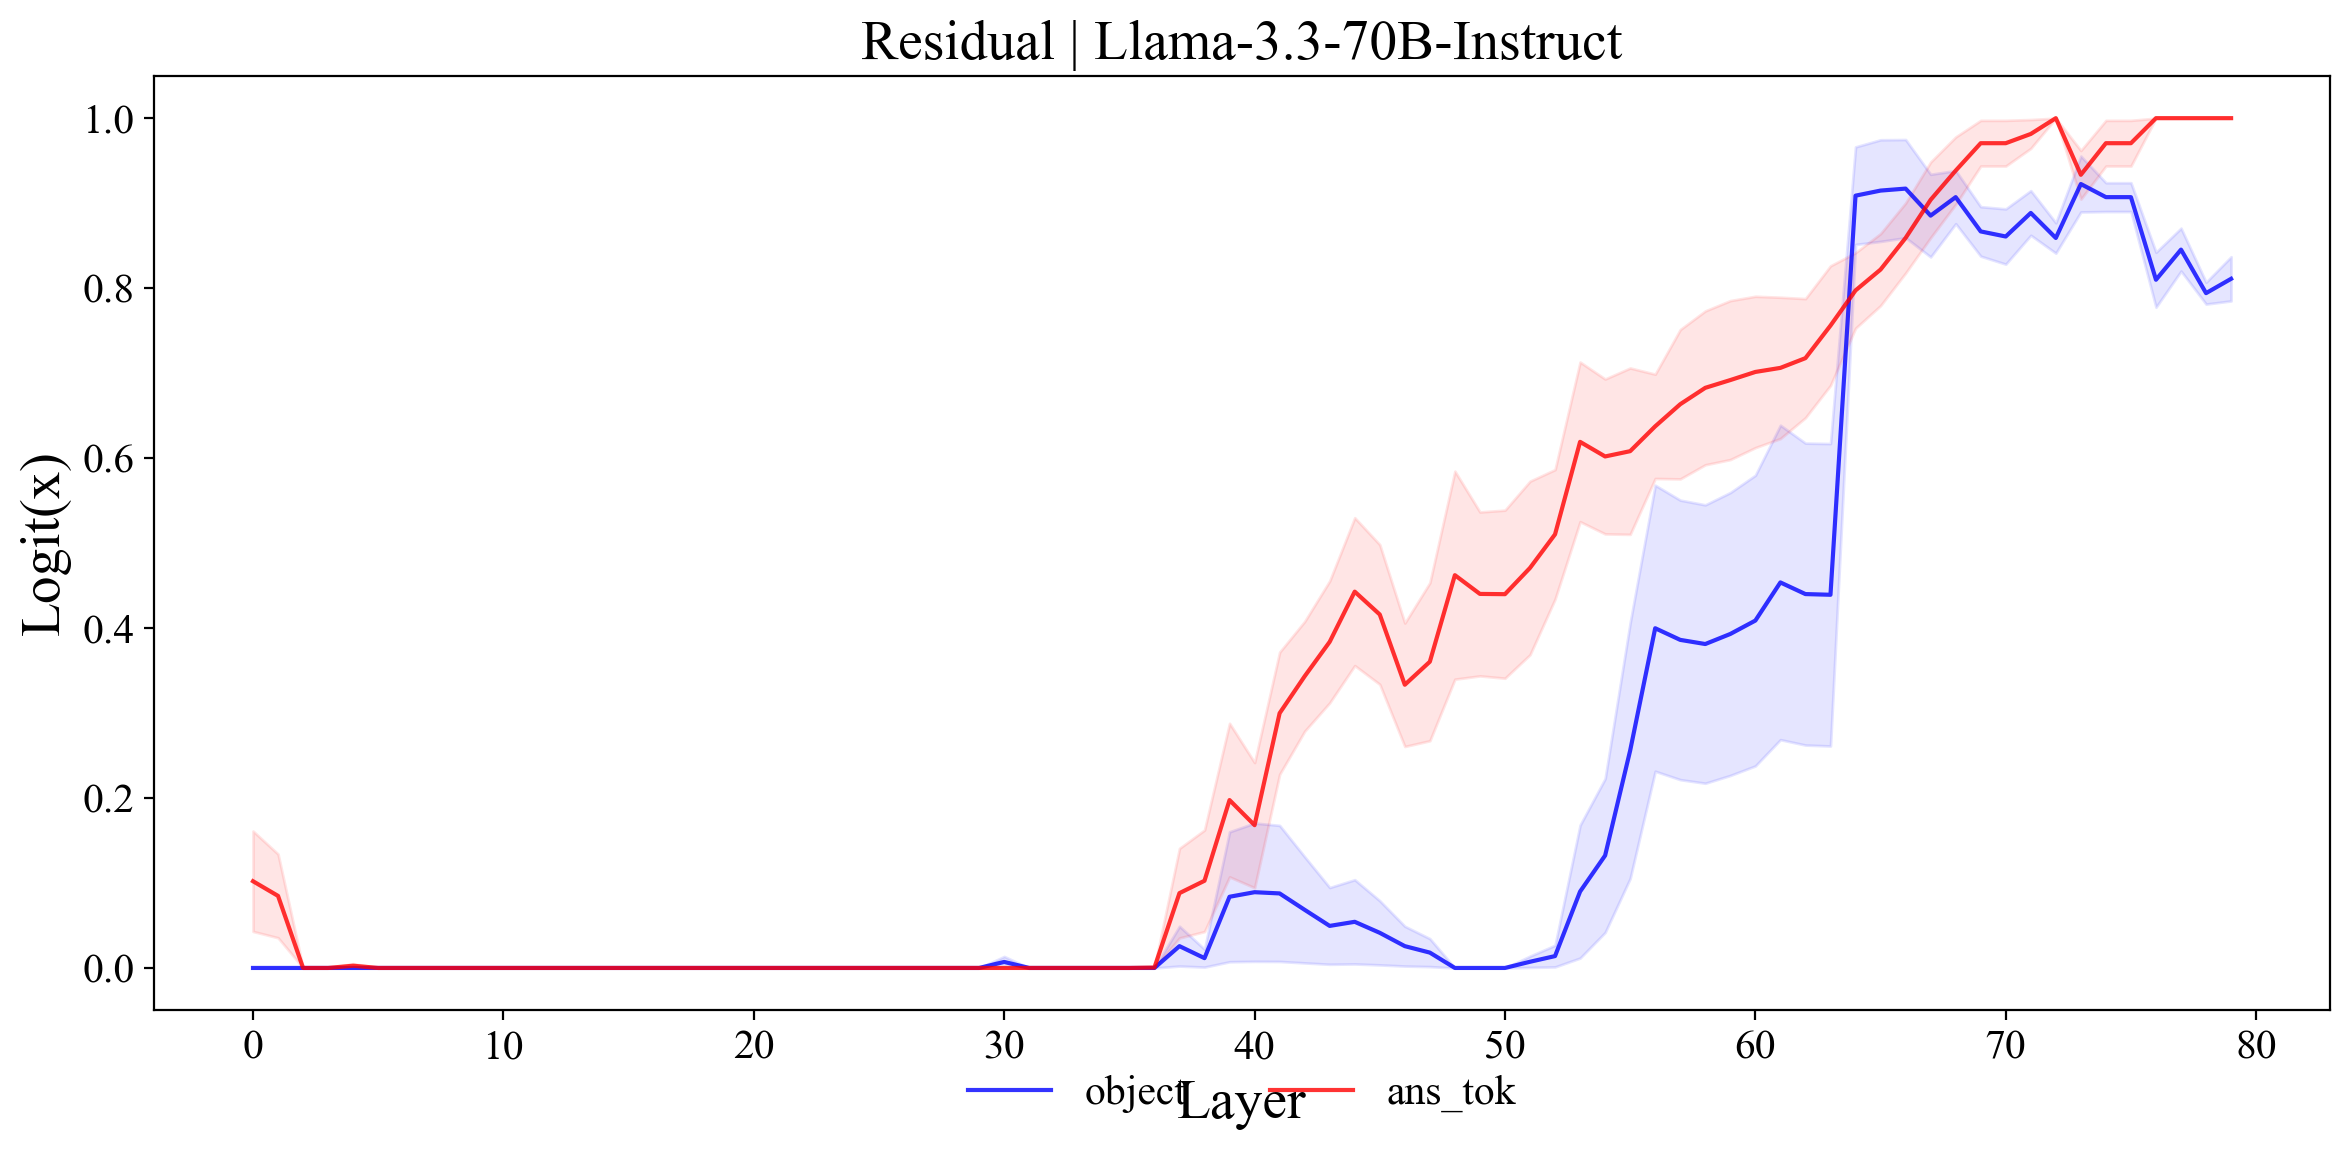

In [88]:
import numpy as np

# Create a figure with a single subplot
from matplotlib import pyplot as plt

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 35

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
colors = {
    "object": "blue",
    "ans_tok": "red",
}

# Plot logits on the panel
lines = []
for token_type, layerwise_scores_list in scores.items():
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(
        len(layerwise_scores_list)
    )
    line, = ax1.plot(mean_scores, label=f"{token_type}", alpha=0.8, color=colors[token_type])
    ax1.fill_between(
        range(len(mean_scores)),
        mean_scores - sterr_scores,
        mean_scores + sterr_scores,
        alpha=0.1,
        color=colors[token_type],
    )
    lines.append(line)

ax1.set_xlabel("Layer")
ax1.set_ylabel("Logit(x)")
ax1.set_title(f"Residual | {mt.name.split('/')[-1]}")

# Place the legend horizontally on top of the panel
ax1.legend(
    handles=lines,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(scores),
    frameon=False,
    fontsize="medium"
)

plt.tight_layout()
save_dir = os.path.join("figures", model_key.split("/")[-1], "logit_lens_contribution")
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, f"template_{prompt_template_idx}_mcq.pdf"), bbox_inches="tight")